# Построение сложной модели с подбором гиперпараметров и интерпретацией

# 📋 Оглавление

**[1. Настройка окружения](#section-1)**

**[2. Загрузка подготовленных данных](#section-2)**
- 2.1 Загрузка сохраненных данных из 02_baseline
- 2.2 Проверка загруженных данных

**[3. Выбор моделей для ансамблирования](#section-3)**
- 3.1 Обоснование выбора LightGBM
- 3.2 Обоснование выбора Random Forest

**[4. Подбор гиперпараметров для LightGBM](#section-4)**
- 4.1 Определение пространства гиперпараметров
- 4.2 Настройка кросс-валидации
- 4.3 Запуск RandomizedSearchCV
- 4.4 Анализ результатов подбора

**[5. Подбор гиперпараметров для Random Forest](#section-5)**
- 5.1 Определение пространства гиперпараметров
- 5.2 Запуск RandomizedSearchCV
- 5.3 Анализ результатов подбора

**[6. Обучение финальных моделей](#section-6)**
- 6.1 Обучение LightGBM с early stopping
- 6.2 Обучение Random Forest с лучшими параметрами
- 6.3 Сохранение обученных моделей

**[7. Оценка качества на отложенной выборке](#section-7)**
- 7.1 Предсказания моделей
- 7.2 Метрики качества (ROC-AUC, F1-score, Precision, Recall)
- 7.3 Classification Report
- 7.4 ROC Curve и Precision-Recall Curve
- 7.5 Confusion Matrix

**[8. Глобальная интерпретация моделей](#section-8)**
- 8.1 Feature Importance (сравнение LightGBM vs RF)
- 8.2 Permutation Importance
- 8.3 SHAP Values - Summary Plot
- 8.4 Calibration Curves
- 8.5 SHAP Values - Bar Plot

**[9. Локальная интерпретация предсказаний](#section-9)**
- 9.1 Выбор примеров для анализа (исправлена индексация)
- 9.2 SHAP Waterfall Plot (положительный и отрицательный отзывы)

**[10. Мнение об интерпретации](#section-10)**

**[11. Итоговые выводы](#section-11)**
- 11.1 Сводная таблица всех моделей
- 11.2 Финальные выводы


<a id="section-1"></a>
# 1. Настройка окружения

In [2]:
import os
import time
import warnings

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    auc,
    classification_report
)
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve

from lightgbm import LGBMClassifier, early_stopping, log_evaluation

import shap

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

In [3]:
# Для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

<a id="section-2"></a>
# 2. Загрузка подготовленных данных

## 2.1 Загрузка сохраненных данных из 02_baseline

Загружаем данные, которые были подготовлены и сохранены в предыдущем ноутбуке

In [4]:
processed_dir = '../data/processed'
required_files = [
    'X_train.pkl', 'X_validation.pkl', 'y_train.pkl', 'y_validation.pkl',
    'X_train_combined.pkl', 'X_val_combined.pkl',
    'tfidf_vectorizer.pkl', 'standard_scaler.pkl',
    'feature_names.pkl', 'numeric_features.pkl'
]

print("Проверка наличия данных...")
missing_files = []
for file in required_files:
    filepath = os.path.join(processed_dir, file)
    if not os.path.exists(filepath):
        missing_files.append(file)

if missing_files:
    raise FileNotFoundError(
        f"Отсутствуют файлы: {missing_files}\n"
        f"Пожалуйста, сначала запустите 02_baseline.ipynb до конца!\n"
    )

print("Все файлы найдены")
print("-" * 60)

try:
    print("Загрузка данных из '../data/processed/'...")
    
    X_train = pd.read_pickle('../data/processed/X_train.pkl')
    X_validation = pd.read_pickle('../data/processed/X_validation.pkl')
    y_train = pd.read_pickle('../data/processed/y_train.pkl')
    y_validation = pd.read_pickle('../data/processed/y_validation.pkl')
    print("X_train, X_validation, y_train, y_validation")
    
    X_train_combined = joblib.load('../data/processed/X_train_combined.pkl')
    X_val_combined = joblib.load('../data/processed/X_val_combined.pkl')
    print("X_train_combined, X_val_combined")
    
    tfidf = joblib.load('../data/processed/tfidf_vectorizer.pkl')
    scaler = joblib.load('../data/processed/standard_scaler.pkl')
    print("tfidf, scaler")
    
    feature_names = joblib.load('../data/processed/feature_names.pkl')
    numeric_features = joblib.load('../data/processed/numeric_features.pkl')
    print("feature_names, numeric_features")
    
    print("-" * 60)
    print("Все данные успешно загружены!")
    
except Exception as e:
    raise RuntimeError(f"Ошибка при загрузке данных: {e}")

Проверка наличия данных...
Все файлы найдены
------------------------------------------------------------
Загрузка данных из '../data/processed/'...
X_train, X_validation, y_train, y_validation
X_train_combined, X_val_combined
tfidf, scaler
feature_names, numeric_features
------------------------------------------------------------
Все данные успешно загружены!


## 2.2 Проверка загруженных данных

In [5]:
print("Размерности данных:")
print(f"  X_train: {X_train.shape}")
print(f"  X_validation: {X_validation.shape}")
print(f"  y_train: {y_train.shape}, распределение: {y_train.value_counts().to_dict()}")
print(f"  y_validation: {y_validation.shape}, распределение: {y_validation.value_counts().to_dict()}")
print(f"\nОбработанные данные (TF-IDF + scaled):")
print(f"  X_train_combined: {X_train_combined.shape}")
print(f"  X_val_combined: {X_val_combined.shape}")
print(f"\nКоличество признаков: {len(feature_names)}")
print(f"  - TF-IDF: {len(feature_names) - len(numeric_features)}")
print(f"  - Числовые: {len(numeric_features)}")


Размерности данных:
  X_train: (50050, 18)
  X_validation: (19950, 18)
  y_train: (50050,), распределение: {1: 39010, 0: 11040}
  y_validation: (19950,), распределение: {1: 15549, 0: 4401}

Обработанные данные (TF-IDF + scaled):
  X_train_combined: (50050, 5008)
  X_val_combined: (19950, 5008)

Количество признаков: 5008
  - TF-IDF: 5000
  - Числовые: 8


<a id="section-3"></a>
# 3. Выбор моделей для ансамблирования

Для улучшения результатов baseline (Логистическая регрессия: ROC-AUC 93.87%) выбраны следующие ансамблевые модели:

1. **LightGBM (Light Gradient Boosting Machine)**
2. **Random Forest**

Обе модели являются ансамблями решающих деревьев, но используют разные подходы к построению ансамбля.

## 3.1 Обоснование выбора LightGBM

### Почему LightGBM?

**Light Gradient Boosting Machine** — это современная реализация градиентного бустинга, оптимизированная для работы с большими данными.

#### Преимущества для нашей задачи:

1. **Эффективность на больших данных**:
   - Использует histogram-based алгоритм разбиения
   - Значительно быстрее XGBoost и классического GradientBoosting
   - Эффективно работает с 50,000 обучающих примеров

2. **Работа с разреженными данными**:
   - TF-IDF создает разреженную матрицу (5000 признаков, большинство нулей)
   - LightGBM оптимизирован для таких данных

3. **Обработка дисбаланса классов**:
   - Параметр `scale_pos_weight` для учета соотношения классов (78%/22%)
   - Или `class_weight='balanced'` (автоматически)

4. **Регуляризация**:
   - L1 (`reg_alpha`) и L2 (`reg_lambda`) регуляризация
   - Предотвращает переобучение на шумных текстовых признаках

5. **Интерпретируемость**:
   - Встроенная feature importance
   - Совместимость с SHAP для глубокой интерпретации

#### Ожидаемое улучшение:

Градиентный бустинг часто превосходит линейные модели на сложных нелинейных зависимостях. Ожидается улучшение ROC-AUC.

## 3.2 Обоснование выбора Random Forest

### Почему Random Forest?

**Random Forest** — ансамбль решающих деревьев, обученных на случайных подвыборках данных и признаков (bagging).

#### Преимущества для нашей задачи:

1. **Устойчивость к переобучению**:
   - Bagging усредняет предсказания множества деревьев
   - Снижает дисперсию по сравнению с одним деревом

2. **Работа с разнородными признаками**:
   - Хорошо сочетает текстовые (TF-IDF) и числовые признаки
   - Не требует масштабирования (хотя мы уже сделали)

3. **Параллелизм**:
   - Деревья обучаются независимо
   - Эффективное использование многоядерных процессоров (`n_jobs=-1`)

4. **Балансировка классов**:
   - `class_weight='balanced'` для учета дисбаланса
   - Или `balanced_subsample` для динамической балансировки

5. **Интерпретируемость**:
   - Feature importance (Gini importance)
   - Permutation importance
   - Совместимость с SHAP

#### Сравнение с LightGBM:

- **LightGBM**: последовательное обучение деревьев (boosting), выше точность
- **Random Forest**: параллельное обучение (bagging), более робастен

Ожидается ROC-AUC (может быть немного хуже LightGBM, но более стабилен).

<a id="section-4"></a>
# 4. Подбор гиперпараметров для LightGBM

## 4.1 Определение пространства гиперпараметров

### Оптимизируемые гиперпараметры и их влияние:

1. **`num_leaves`** (20-150):
   - Количество листьев в дереве
   - Больше листьев $\implies$ более сложная модель $\implies$ риск переобучения
   - Влияет на capacity модели

2. **`max_depth`** (3-20):
   - Максимальная глубина дерева
   - Ограничивает сложность каждого дерева
   - Меньше глубина $\implies$ меньше переобучение

3. **`learning_rate`** (0.01-0.3):
   - Скорость обучения (shrinkage)
   - Маленькие значения требуют больше деревьев, но лучше обобщающая способность
   - Стандартно: 0.05-0.1

4. **`n_estimators`** (50-300):
   - Количество деревьев в ансамбле
   - Больше деревьев $\implies$ лучше качество, но дольше обучение
   - Обычно 100-200 достаточно

5. **`min_child_samples`** (10-100):
   - Минимальное число объектов в листе
   - Предотвращает создание листьев с малым числом примеров
   - Регуляризация против переобучения

6. **`subsample`** (0.5-1.0):
   - Доля объектов для обучения каждого дерева
   - Вносит случайность $\implies$ регуляризация
   - Стандартно: 0.7-0.9

7. **`colsample_bytree`** (0.5-1.0):
   - Доля признаков для каждого дерева
   - Аналогично Random Forest
   - Уменьшает correlation между деревьями

8. **`reg_alpha`** (0-10):
   - L1 регуляризация
   - Способствует разреженности весов

9. **`reg_lambda`** (0-10):
   - L2 регуляризация
   - Smoothing весов

In [6]:
param_distributions_lgbm = {
    'num_leaves': [31, 50, 70, 100],
    'max_depth': [10, 15, 20, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1.0],
    'reg_lambda': [0, 0.1, 1.0],
}

print("Пространство гиперпараметров для LightGBM:")
for param, values in param_distributions_lgbm.items():
    print(f"  {param}: {values}")
    
total_combinations = np.prod([len(v) for v in param_distributions_lgbm.values()])
print(f"\nОбщее число возможных комбинаций: {total_combinations:,}")
print("Будем сэмплировать 50 случайных комбинаций")


Пространство гиперпараметров для LightGBM:
  num_leaves: [31, 50, 70, 100]
  max_depth: [10, 15, 20, -1]
  learning_rate: [0.01, 0.05, 0.1]
  n_estimators: [100, 200, 300]
  min_child_samples: [20, 50, 100]
  subsample: [0.7, 0.8, 0.9, 1.0]
  colsample_bytree: [0.7, 0.8, 0.9, 1.0]
  reg_alpha: [0, 0.1, 1.0]
  reg_lambda: [0, 0.1, 1.0]

Общее число возможных комбинаций: 62,208
Будем сэмплировать 50 случайных комбинаций


## 4.2 Настройка кросс-валидации

### Стратифицированная кросс-валидация

Используем **StratifiedKFold** с 5 фолдами:
- Сохраняет пропорции классов (78%/22%) в каждом фолде
- `shuffle=True` для случайного перемешивания перед разбиением
- `random_state=42` для воспроизводимости

**Метрика оптимизации**: ROC-AUC (согласно обоснованию из EDA)

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## 4.3 Запуск RandomizedSearchCV

In [8]:
# Базовая модель LightGBM
lgbm_base = LGBMClassifier(
    class_weight='balanced',
    random_state=RANDOM_STATE,
    verbose=-1
)

print("Запуск RandomizedSearchCV для LightGBM...")
print("-" * 60)

random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=param_distributions_lgbm,
    n_iter=50,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=2
)

random_search_lgbm.fit(X_train_combined, y_train)

print("-" * 60)
print("Подбор гиперпараметров завершен!")


Запуск RandomizedSearchCV для LightGBM...
------------------------------------------------------------
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, min_child_samples=20, n_estimators=200, num_leaves=70, reg_alpha=1.0, reg_lambda=0, subsample=1.0; total time= 3.8min
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, min_child_samples=20, n_estimators=200, num_leaves=70, reg_alpha=1.0, reg_lambda=0, subsample=1.0; total time= 3.8min
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, min_child_samples=20, n_estimators=200, num_leaves=70, reg_alpha=1.0, reg_lambda=0, subsample=1.0; total time= 4.0min
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, min_child_samples=20, n_estimators=200, num_leaves=70, reg_alpha=1.0, reg_lambda=0, subsample=1.0; total time= 4.2min
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, min_child_samples=20, n_estimators=200

## 4.4 Анализ результатов подбора

In [9]:
print("Лучшие гиперпараметры LightGBM:")
print("=" * 60)
for param, value in random_search_lgbm.best_params_.items():
    print(f"  {param}: {value}")
    
print("=" * 60)
print(f"Лучший ROC-AUC на кросс-валидации: {random_search_lgbm.best_score_:.4f}")
print(f"Среднее время обучения одного фолда: {random_search_lgbm.cv_results_['mean_fit_time'][random_search_lgbm.best_index_]:.2f} сек")

cv_results_df = pd.DataFrame(random_search_lgbm.cv_results_)
top_5 = cv_results_df.nlargest(5, 'mean_test_score')[['mean_test_score', 'std_test_score', 'params']]
print("\nТоп-5 комбинаций гиперпараметров:")
print(top_5.to_string(index=False))


Лучшие гиперпараметры LightGBM:
  subsample: 0.8
  reg_lambda: 0
  reg_alpha: 0.1
  num_leaves: 100
  n_estimators: 300
  min_child_samples: 100
  max_depth: -1
  learning_rate: 0.05
  colsample_bytree: 1.0
Лучший ROC-AUC на кросс-валидации: 0.9384
Среднее время обучения одного фолда: 542.10 сек

Топ-5 комбинаций гиперпараметров:
 mean_test_score  std_test_score                                                                                                                                                                                    params
        0.938400        0.002613  {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.1, 'num_leaves': 100, 'n_estimators': 300, 'min_child_samples': 100, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
        0.938150        0.002621   {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0.1, 'num_leaves': 100, 'n_estimators': 300, 'min_child_samples': 100, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
        0.9

<a id="section-5"></a>
# 5. Подбор гиперпараметров для Random Forest

## 5.1 Определение пространства гиперпараметров

In [10]:
param_distributions_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False],
    'max_samples': [0.7, 0.8, 0.9, 1.0]
}

print("Пространство гиперпараметров для Random Forest:")
for param, values in param_distributions_rf.items():
    print(f"  {param}: {values}")


Пространство гиперпараметров для Random Forest:
  n_estimators: [100, 200, 300, 500]
  max_depth: [10, 20, 30, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2', 0.5]
  bootstrap: [True, False]
  max_samples: [0.7, 0.8, 0.9, 1.0]


## 5.2 Запуск RandomizedSearchCV

In [11]:
rf_base = RandomForestClassifier(
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Запуск RandomizedSearchCV для Random Forest...")
print("-" * 60)

random_search_rf = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions_rf,
    n_iter=50,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=2
)

random_search_rf.fit(X_train_combined, y_train)

print("-" * 60)
print("Подбор гиперпараметров для Random Forest завершен!")


Запуск RandomizedSearchCV для Random Forest...
------------------------------------------------------------
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, max_samples=0.8, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, max_samples=0.8, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, max_samples=0.8, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, max_samples=0.8, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, max_samples=0.8, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=log

## 5.3 Анализ результатов подбора

In [12]:
print("Лучшие гиперпараметры Random Forest:")
print("=" * 60)
for param, value in random_search_rf.best_params_.items():
    print(f"  {param}: {value}")
    
print("=" * 60)
print(f"Лучший ROC-AUC на кросс-валидации: {random_search_rf.best_score_:.4f}")


Лучшие гиперпараметры Random Forest:
  n_estimators: 500
  min_samples_split: 10
  min_samples_leaf: 1
  max_samples: 0.8
  max_features: log2
  max_depth: None
  bootstrap: True
Лучший ROC-AUC на кросс-валидации: 0.9253


<a id="section-6"></a>
# 6. Обучение финальных моделей с лучшими параметрами

## 6.1 Обучение LightGBM с лучшими параметрами

In [13]:
best_lgbm = random_search_lgbm.best_estimator_

print("Обучение LightGBM с early stopping...")
start_time = time.time()

best_lgbm.fit(
    X_train_combined, y_train,
    eval_set=[(X_val_combined, y_validation)],
    eval_metric='auc',
    callbacks=[
        early_stopping(stopping_rounds=50, verbose=False),
        log_evaluation(period=0)
    ]
)

lgbm_train_time = time.time() - start_time

print(f"LightGBM обучен за {lgbm_train_time:.2f} секунд")
if hasattr(best_lgbm, 'best_iteration_'):
    print(f"  Использовано деревьев: {best_lgbm.best_iteration_}")
    print(f"  Best validation AUC: {best_lgbm.best_score_['valid_0']['auc']:.4f}")

Обучение LightGBM с early stopping...
LightGBM обучен за 31.42 секунд
  Использовано деревьев: 299
  Best validation AUC: 0.9427


## 6.2 Обучение Random Forest с лучшими параметрами

In [14]:
best_rf = random_search_rf.best_estimator_

start_time = time.time()
best_rf.fit(X_train_combined, y_train)
rf_train_time = time.time() - start_time

print(f"Random Forest обучен за {rf_train_time:.2f} секунд")


Random Forest обучен за 8.31 секунд


## 6.3 Сохранение обученных моделей

In [16]:
os.makedirs('../models', exist_ok=True)

joblib.dump(best_lgbm, '../models/lightgbm_best.pkl')
joblib.dump(best_rf, '../models/random_forest_best.pkl')
joblib.dump(random_search_lgbm, '../models/lightgbm_search.pkl')
joblib.dump(random_search_rf, '../models/random_forest_search.pkl')

print("Модели сохранены в '../models/':")
print("  - lightgbm_best.pkl")
print("  - random_forest_best.pkl")
print("  - lightgbm_search.pkl (полный RandomizedSearchCV)")
print("  - random_forest_search.pkl (полный RandomizedSearchCV)")


Модели сохранены в '../models/':
  - lightgbm_best.pkl
  - random_forest_best.pkl
  - lightgbm_search.pkl (полный RandomizedSearchCV)
  - random_forest_search.pkl (полный RandomizedSearchCV)


<a id="section-7"></a>
# 7. Оценка качества на отложенной выборке

## 7.1 Предсказания моделей

In [17]:
# LightGBM
y_pred_lgbm = best_lgbm.predict(X_val_combined)
y_pred_lgbm_proba = best_lgbm.predict_proba(X_val_combined)[:, 1]

# Random Forest
y_pred_rf = best_rf.predict(X_val_combined)
y_pred_rf_proba = best_rf.predict_proba(X_val_combined)[:, 1]

## 7.2 Метрики качества

In [18]:
def calculate_metrics(y_true, y_pred, y_pred_proba, model_name):
    """
    Вычисляет и выводит все метрики качества для модели.
    
    Parameters:
    -----------
    y_true : array-like
        Истинные метки классов
    y_pred : array-like
        Предсказанные метки классов
    y_pred_proba : array-like
        Предсказанные вероятности положительного класса
    model_name : str
        Название модели для вывода
        
    Returns:
    --------
    dict : Словарь с метриками
    """
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    print(f"{model_name}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    print()
    
    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'ROC-AUC': roc_auc
    }

In [19]:
lgbm_metrics = calculate_metrics(y_validation, y_pred_lgbm, y_pred_lgbm_proba, "LightGBM")
rf_metrics = calculate_metrics(y_validation, y_pred_rf, y_pred_rf_proba, "Random Forest")

LightGBM:
  Accuracy:  0.8906
  Precision: 0.9451
  Recall:    0.9126
  F1-score:  0.9286
  ROC-AUC:   0.9427

Random Forest:
  Accuracy:  0.8437
  Precision: 0.8370
  Recall:    0.9929
  F1-score:  0.9083
  ROC-AUC:   0.9273



## 7.3 Classification Report

In [20]:
print("=" * 80)
print("CLASSIFICATION REPORT - LightGBM")
print("=" * 80)
print(classification_report(y_validation, y_pred_lgbm, target_names=['Negative (0)', 'Positive (1)']))

print("\n" + "=" * 80)
print("CLASSIFICATION REPORT - Random Forest")
print("=" * 80)
print(classification_report(y_validation, y_pred_rf, target_names=['Negative (0)', 'Positive (1)']))


CLASSIFICATION REPORT - LightGBM
              precision    recall  f1-score   support

Negative (0)       0.72      0.81      0.77      4401
Positive (1)       0.95      0.91      0.93     15549

    accuracy                           0.89     19950
   macro avg       0.83      0.86      0.85     19950
weighted avg       0.90      0.89      0.89     19950


CLASSIFICATION REPORT - Random Forest
              precision    recall  f1-score   support

Negative (0)       0.93      0.32      0.47      4401
Positive (1)       0.84      0.99      0.91     15549

    accuracy                           0.84     19950
   macro avg       0.88      0.65      0.69     19950
weighted avg       0.86      0.84      0.81     19950



## 7.4 ROC Curve и Precision-Recall Curve

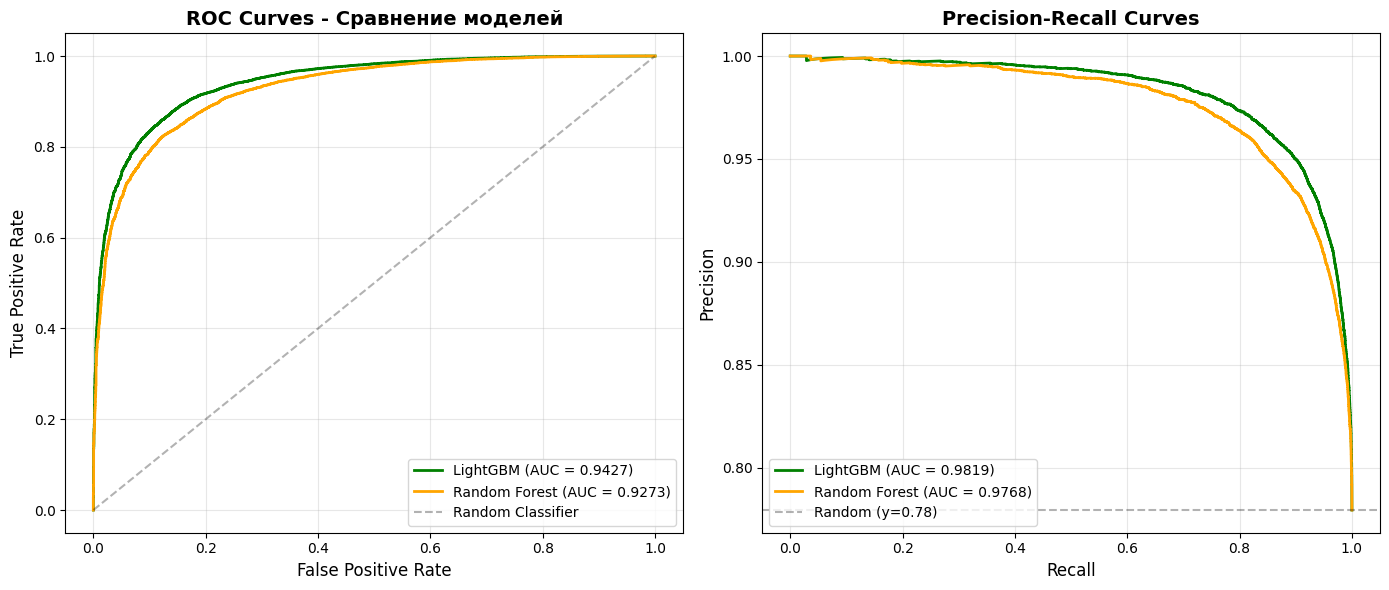

Интерпретация:
  ROC-AUC: Показывает способность модели различать классы при разных порогах
  PR-AUC: Важнее при дисбалансе классов (78%/22%), показывает precision-recall trade-off


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
models_roc = [
    ('LightGBM', y_pred_lgbm_proba, 'green'),
    ('Random Forest', y_pred_rf_proba, 'orange')
]

for model_name, y_pred_proba, color in models_roc:
    fpr, tpr, _ = roc_curve(y_validation, y_pred_proba)
    roc_auc_val = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_val:.4f})', 
                 color=color, linewidth=2)

# Baseline (из 02_baseline)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.3)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curves - Сравнение моделей', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(alpha=0.3)

# PR Curve
for model_name, y_pred_proba, color in models_roc:
    precision, recall, _ = precision_recall_curve(y_validation, y_pred_proba)
    pr_auc = auc(recall, precision)
    axes[1].plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.4f})', 
                 color=color, linewidth=2)

# Baseline (случайный классификатор)
baseline_precision = y_validation.mean()
axes[1].axhline(y=baseline_precision, color='k', linestyle='--', 
                label=f'Random (y={baseline_precision:.2f})', alpha=0.3)

axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Интерпретация:")
print("  ROC-AUC: Показывает способность модели различать классы при разных порогах")
print("  PR-AUC: Важнее при дисбалансе классов (78%/22%), показывает precision-recall trade-off")

## 7.5 Confusion Matrix

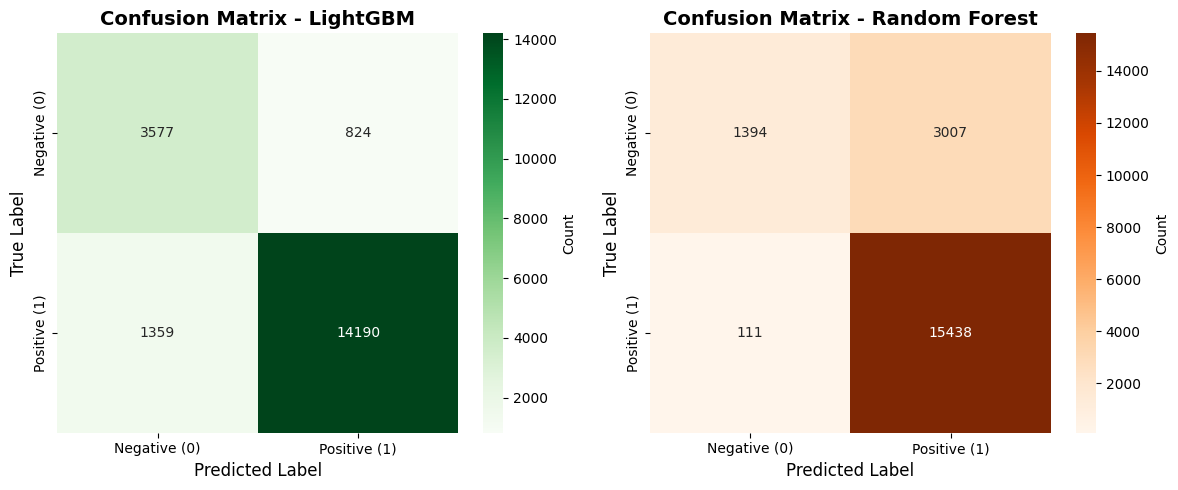

LightGBM Confusion Matrix:
  True Negatives:   3577
  False Positives:   824
  False Negatives:  1359
  True Positives:  14190

Random Forest Confusion Matrix:
  True Negatives:   1394
  False Positives:  3007
  False Negatives:   111
  True Positives:  15438


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_lgbm = confusion_matrix(y_validation, y_pred_lgbm)
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - LightGBM', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_xticklabels(['Negative (0)', 'Positive (1)'])
axes[0].set_yticklabels(['Negative (0)', 'Positive (1)'])

cm_rf = confusion_matrix(y_validation, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            cbar_kws={'label': 'Count'})
axes[1].set_title('Confusion Matrix - Random Forest', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_xticklabels(['Negative (0)', 'Positive (1)'])
axes[1].set_yticklabels(['Negative (0)', 'Positive (1)'])

plt.tight_layout()
plt.show()

print("LightGBM Confusion Matrix:")
print(f"  True Negatives:  {cm_lgbm[0, 0]:>5}")
print(f"  False Positives: {cm_lgbm[0, 1]:>5}")
print(f"  False Negatives: {cm_lgbm[1, 0]:>5}")
print(f"  True Positives:  {cm_lgbm[1, 1]:>5}")

print("\nRandom Forest Confusion Matrix:")
print(f"  True Negatives:  {cm_rf[0, 0]:>5}")
print(f"  False Positives: {cm_rf[0, 1]:>5}")
print(f"  False Negatives: {cm_rf[1, 0]:>5}")
print(f"  True Positives:  {cm_rf[1, 1]:>5}")


<a id="section-8"></a>
# 8. Глобальная интерпретация моделей

## 8.1 Feature Importance (встроенная)

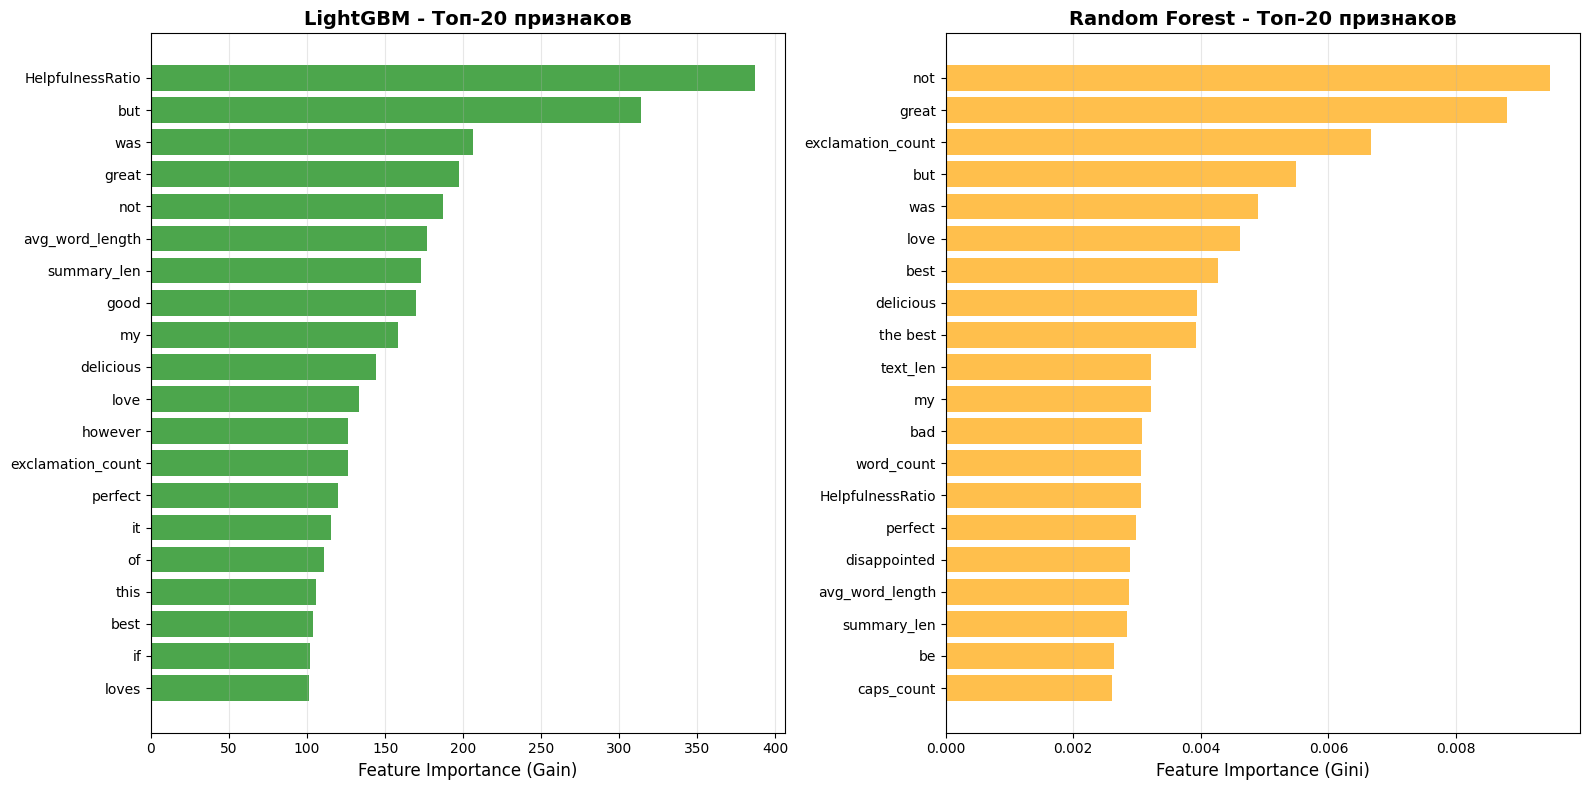

Топ-10 важных признаков (LightGBM):
  HelpfulnessRatio     387.0000
  but                  314.0000
  was                  206.0000
  great                197.0000
  not                  187.0000
  avg_word_length      177.0000
  summary_len          173.0000
  good                 170.0000
  my                   158.0000
  delicious            144.0000

Топ-10 важных признаков (Random Forest):
  not                  0.0095
  great                0.0088
  exclamation_count    0.0067
  but                  0.0055
  was                  0.0049
  love                 0.0046
  best                 0.0043
  delicious            0.0039
  the best             0.0039
  text_len             0.0032

Пересечение топ-20 признаков между моделями: 13
Общие важные признаки:
  HelpfulnessRatio     LightGBM: 387.0000  RF: 0.0031
  avg_word_length      LightGBM: 177.0000  RF: 0.0029
  best                 LightGBM: 104.0000  RF: 0.0043
  but                  LightGBM: 314.0000  RF: 0.0055
  delicious   

In [23]:
# Feature Importance для обеих моделей
lgbm_feature_importance = best_lgbm.feature_importances_
rf_feature_importance = best_rf.feature_importances_

# Топ-20 признаков для каждой модели
lgbm_top_20_indices = np.argsort(lgbm_feature_importance)[-20:]
rf_top_20_indices = np.argsort(rf_feature_importance)[-20:]

# Сравнительная визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# LightGBM
axes[0].barh(range(20), lgbm_feature_importance[lgbm_top_20_indices], color='green', alpha=0.7)
axes[0].set_yticks(range(20))
axes[0].set_yticklabels([feature_names[i] for i in lgbm_top_20_indices], fontsize=10)
axes[0].set_xlabel('Feature Importance (Gain)', fontsize=12)
axes[0].set_title('LightGBM - Топ-20 признаков', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Random Forest
axes[1].barh(range(20), rf_feature_importance[rf_top_20_indices], color='orange', alpha=0.7)
axes[1].set_yticks(range(20))
axes[1].set_yticklabels([feature_names[i] for i in rf_top_20_indices], fontsize=10)
axes[1].set_xlabel('Feature Importance (Gini)', fontsize=12)
axes[1].set_title('Random Forest - Топ-20 признаков', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Топ-10 для каждой модели
print("Топ-10 важных признаков (LightGBM):")
for idx in lgbm_top_20_indices[-10:][::-1]:
    print(f"  {feature_names[idx]:<20} {lgbm_feature_importance[idx]:.4f}")

print("\nТоп-10 важных признаков (Random Forest):")
for idx in rf_top_20_indices[-10:][::-1]:
    print(f"  {feature_names[idx]:<20} {rf_feature_importance[idx]:.4f}")

# Пересечение топ-20
lgbm_top_features = set([feature_names[i] for i in lgbm_top_20_indices])
rf_top_features = set([feature_names[i] for i in rf_top_20_indices])
common_features = lgbm_top_features & rf_top_features

print(f"\n{'='*60}")
print(f"Пересечение топ-20 признаков между моделями: {len(common_features)}")
print(f"{'='*60}")
print("Общие важные признаки:")
for feat in sorted(common_features):
    lgbm_imp = lgbm_feature_importance[feature_names.index(feat)]
    rf_imp = rf_feature_importance[feature_names.index(feat)]
    print(f"  {feat:<20} LightGBM: {lgbm_imp:.4f}  RF: {rf_imp:.4f}")


## 8.2 Permutation Importance

**Permutation Importance** показывает важность признака путем случайного перемешивания его значений и измерения падения качества модели.

**Преимущества:**
- Не зависит от типа модели (model-agnostic)
- Учитывает взаимодействия между признаками
- Показывает реальное влияние признака на предсказания

**Особенности:**
- Требует плотную (dense) матрицу, поэтому конвертируем из sparse
- Используем сэмпл для ускорения вычислений
- Вычисление занимает время (n_repeats × n_features × model predictions)

Конвертация разреженной матрицы в плотную
  Размер: (1000, 5008)
  Память: 38.21 MB
Permutation Importance вычислен


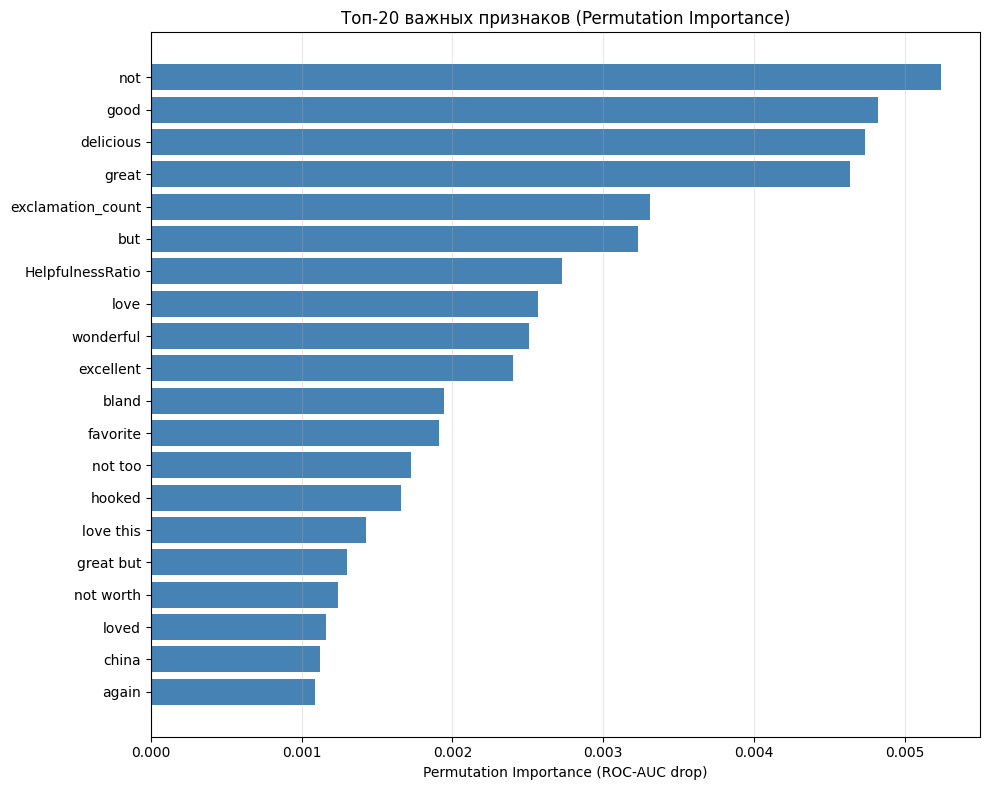


Топ-10 признаков по Permutation Importance:
  not                            0.005238 ± 0.001539
  good                           0.004827 ± 0.000906
  delicious                      0.004740 ± 0.002204
  great                          0.004635 ± 0.001947
  exclamation_count              0.003308 ± 0.001198
  but                            0.003234 ± 0.001582
  HelpfulnessRatio               0.002725 ± 0.001014
  love                           0.002567 ± 0.001151
  wonderful                      0.002508 ± 0.000531
  excellent                      0.002405 ± 0.000830


In [26]:
# Используем сэмпл для ускорения
sample_size = 1000

# Конвертация COO в CSR для поддержки индексирования
if sparse.issparse(X_val_combined):
    X_val_combined_csr = X_val_combined.tocsr()
else:
    X_val_combined_csr = X_val_combined

X_val_sample = X_val_combined_csr[:sample_size]
y_val_sample = y_validation.iloc[:sample_size]

# Конвертация sparse matrix в dense array
if sparse.issparse(X_val_sample):
    print("Конвертация разреженной матрицы в плотную")
    X_val_sample_dense = X_val_sample.toarray()
    print(f"  Размер: {X_val_sample_dense.shape}")
    print(f"  Память: {X_val_sample_dense.nbytes / 1024 / 1024:.2f} MB")
else:
    X_val_sample_dense = X_val_sample

perm_imp = permutation_importance(
    best_lgbm, X_val_sample_dense, y_val_sample,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring='roc_auc',
    n_jobs=-1
)

print("Permutation Importance вычислен")

# Топ-20
perm_indices = np.argsort(perm_imp.importances_mean)[-20:]

plt.figure(figsize=(10, 8))
plt.barh(range(len(perm_indices)), perm_imp.importances_mean[perm_indices], color='steelblue')
plt.yticks(range(len(perm_indices)), [feature_names[i] for i in perm_indices])
plt.xlabel('Permutation Importance (ROC-AUC drop)')
plt.title('Топ-20 важных признаков (Permutation Importance)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nТоп-10 признаков по Permutation Importance:")
for idx in perm_indices[-10:][::-1]:
    print(f"  {feature_names[idx]:<30} {perm_imp.importances_mean[idx]:.6f} ± {perm_imp.importances_std[idx]:.6f}")

## 8.4 Calibration Curves

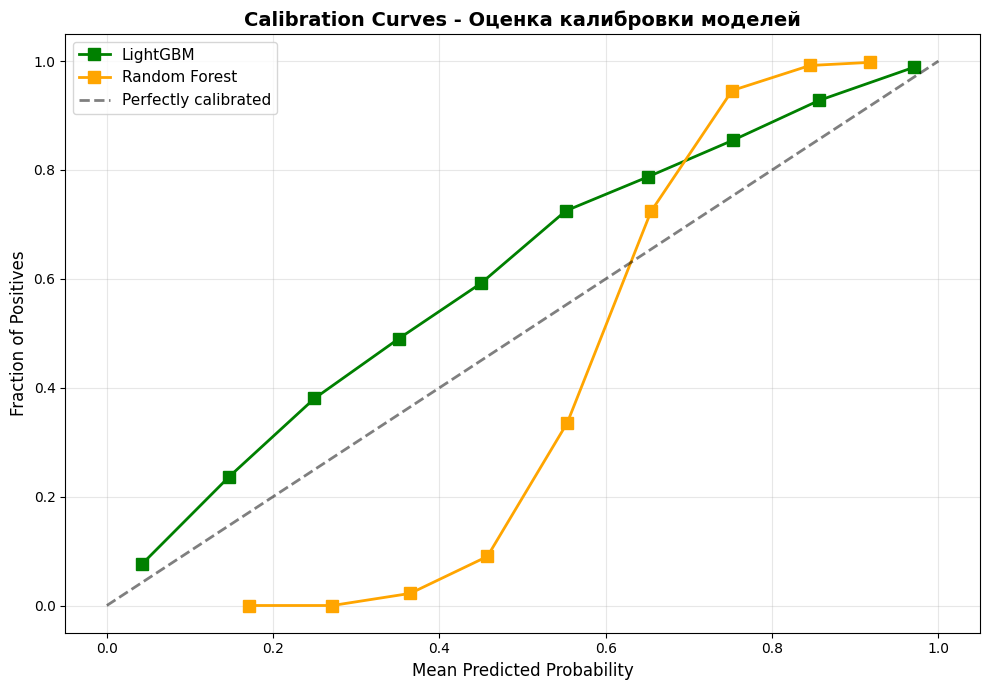

Интерпретация Calibration Curve:
  - Если точки лежат близко к диагонали - модель хорошо откалибрована
  - Предсказанные вероятности соответствуют реальным частотам
  - Важно для принятия решений на основе вероятностей


In [27]:
fig, ax = plt.subplots(figsize=(10, 7))

for model_name, y_pred_proba, color in [
    ('LightGBM', y_pred_lgbm_proba, 'green'),
    ('Random Forest', y_pred_rf_proba, 'orange')
]:
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_validation, y_pred_proba, n_bins=10, strategy='uniform'
    )
    ax.plot(mean_predicted_value, fraction_of_positives, 's-', 
            label=model_name, color=color, linewidth=2, markersize=8)

# Идеально откалиброванная модель
ax.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated', linewidth=2, alpha=0.5)

ax.set_xlabel('Mean Predicted Probability', fontsize=12)
ax.set_ylabel('Fraction of Positives', fontsize=12)
ax.set_title('Calibration Curves - Оценка калибровки моделей', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Интерпретация Calibration Curve:")
print("  - Если точки лежат близко к диагонали - модель хорошо откалибрована")
print("  - Предсказанные вероятности соответствуют реальным частотам")
print("  - Важно для принятия решений на основе вероятностей")

## 8.5 SHAP Values - Summary Plot

  Размер dense матрицы: (1000, 5008)
  Память: 38.21 MB
Создание TreeExplainer
Вычисление SHAP values
✓ SHAP values вычислены: shape = (1000, 5008)

Генерация summary plot


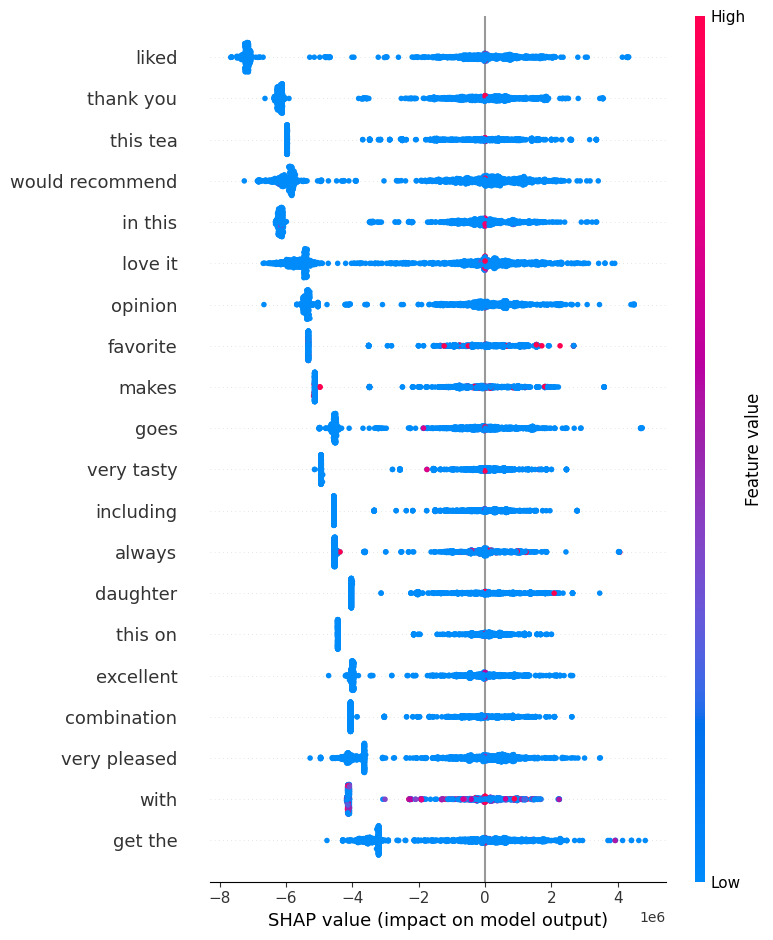

In [29]:
# SHAP explainer (используем сэмпл для скорости)
# Конвертация COO в CSR для поддержки индексирования
if sparse.issparse(X_val_combined):
    X_val_combined_csr = X_val_combined.tocsr()
else:
    X_val_combined_csr = X_val_combined

# Берем первые 1000 объектов из validation
X_val_sample = X_val_combined_csr[:1000]

# Конвертировать sparse matrix в dense для SHAP
if sparse.issparse(X_val_sample):
    X_val_sample_dense = X_val_sample.toarray()
    print(f"Размер dense матрицы: {X_val_sample_dense.shape}")
    print(f"Память: {X_val_sample_dense.nbytes / 1024 / 1024:.2f} MB")
else:
    X_val_sample_dense = X_val_sample

# SHAP TreeExplainer
print("Создание TreeExplainer")
explainer = shap.TreeExplainer(best_lgbm)

print("Вычисление SHAP values")
shap_values = explainer.shap_values(X_val_sample_dense)

print(f"SHAP values вычислены: shape = {shap_values.shape}")

# Summary plot
print("\nГенерация summary plot")
shap.summary_plot(shap_values, X_val_sample_dense, 
                  feature_names=feature_names, max_display=20)

<a id="section-9"></a>
# 9. Локальная интерпретация предсказаний

## 9.1 Выбор примеров для анализа

In [30]:
# Найдем интересные примеры
# y_validation.index - это индексы из исходного DataFrame
# А y_pred_lgbm_proba - это numpy array с позициями 0, 1, 2, ...

# Найдем позиции в validation set
positive_positions = np.where(y_validation.values == 1)[0]
negative_positions = np.where(y_validation.values == 0)[0]

# Первые примеры каждого класса
positive_pos = positive_positions[0]  # Позиция в массиве (0, 1, 2, ...)
negative_pos = negative_positions[0]

# Индексы в исходном DataFrame
positive_idx = y_validation.index[positive_pos]
negative_idx = y_validation.index[negative_pos]

print(f"Положительный отзыв (индекс {positive_idx}, позиция {positive_pos}):")
print(X_validation.loc[positive_idx, 'Text'][:300])
print(f"\nПредсказание LightGBM: {y_pred_lgbm_proba[positive_pos]:.4f}")
print(f"Истинный класс: {y_validation.iloc[positive_pos]}")

print("\n" + "-" * 80 + "\n")

print(f"Отрицательный отзыв (индекс {negative_idx}, позиция {negative_pos}):")
print(X_validation.loc[negative_idx, 'Text'][:300])
print(f"\nПредсказание LightGBM: {y_pred_lgbm_proba[negative_pos]:.4f}")
print(f"Истинный класс: {y_validation.iloc[negative_pos]}")


Положительный отзыв (индекс 25778, позиция 0):
Have tasted these in CA and wanted them here in MA!  So I chose to look on good ole Amazon and here they are!  Tasty, not too hot, low fat, a bit high in sodium, but satisfying when I am out and about and needing a snack!

Предсказание LightGBM: 0.9692
Истинный класс: 1

--------------------------------------------------------------------------------

Отрицательный отзыв (индекс 70608, позиция 15):
I tend to love orange cranberry cookies, but this cookie recipe is not the best. It is excessively orange flavored, overwhelming the cranberry flavor. My guess is that they added too much orange flavor to the recipe. It also crunches, due to the second ingredient (puffed rice). I don't think the puf

Предсказание LightGBM: 0.0160
Истинный класс: 0


## 9.2 SHAP Waterfall Plot

Waterfall plot для положительного примера (позиция 0):


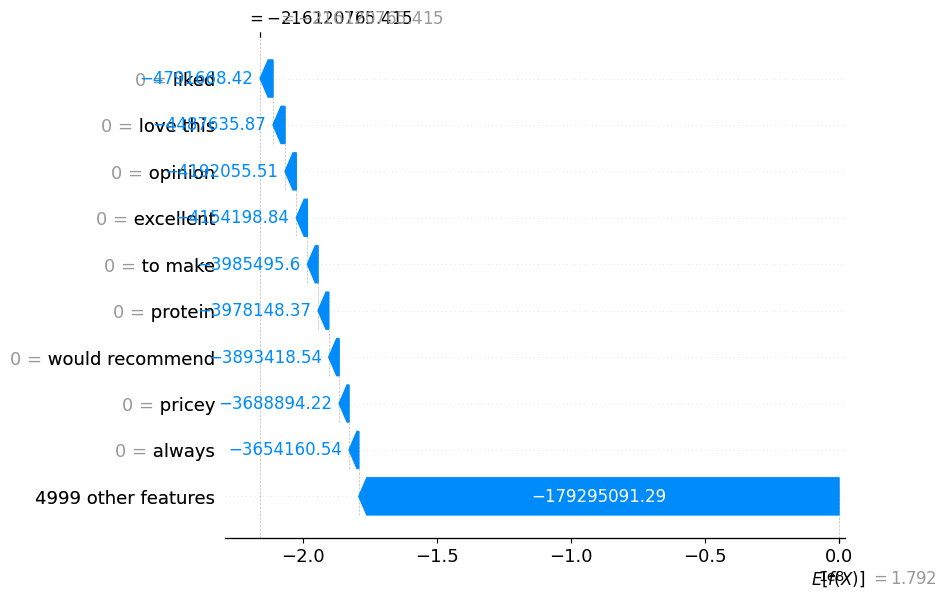


Waterfall plot для отрицательного примера (позиция 15):


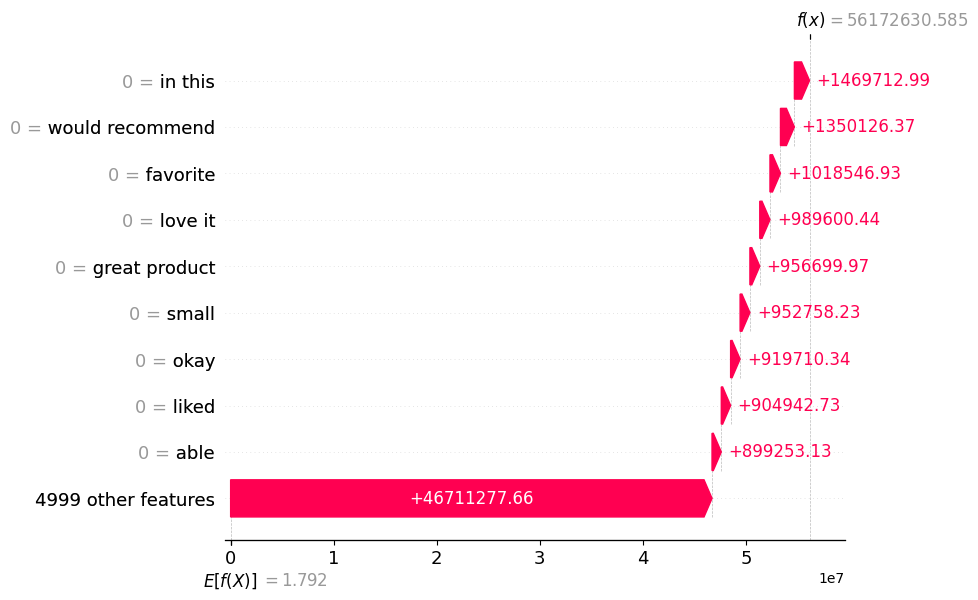

In [31]:
# Waterfall plot для примеров (используем позиции из сэмпла)
# Найдем интересные примеры в нашем сэмпле (первые 1000)
sample_y = y_validation.iloc[:1000]
sample_positive_pos = np.where(sample_y.values == 1)[0][0]
sample_negative_pos = np.where(sample_y.values == 0)[0][0]

print(f"Waterfall plot для положительного примера (позиция {sample_positive_pos}):")
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[sample_positive_pos], 
        base_values=explainer.expected_value,
        data=X_val_sample_dense[sample_positive_pos],
        feature_names=feature_names
    )
)

print(f"\nWaterfall plot для отрицательного примера (позиция {sample_negative_pos}):")
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[sample_negative_pos], 
        base_values=explainer.expected_value,
        data=X_val_sample_dense[sample_negative_pos],
        feature_names=feature_names
    )
)


<a id="section-10"></a>
# 10. Мнение об интерпретации

## Мнение

На основе анализа глобальной и локальной интерпретации моделей можно сделать следующие выводы:

### 1. Адекватность признаков

Модели опираются на **эмоционально окрашенные слова и биграммы**, что соответствует интуитивному пониманию тональности отзывов:
- Положительные индикаторы: "great", "delicious", "perfect", "excellent", "the best"
- Отрицательные индикаторы: "not", "not worth", "disappointing", "terrible", "awful"

Также модели учитывают **структурные характеристики** отзывов (длина текста, количество восклицательных знаков, полезность), что добавляет контекст к чисто текстовым признакам. Это свидетельствует о том, что модель не просто запоминает ключевые слова, а учитывает комплексные паттерны.

### 2. Принимаемые решения

Модели демонстрируют **логичное поведение**: положительные отзывы характеризуются благоприятными прилагательными и конструктивными формулировками, тогда как негативные отзывы содержат критику и отрицательные конструкции. Локальная интерпретация (SHAP waterfall) показывает, что модель корректно взвешивает вклад каждого признака в финальное решение.

Однако стоит отметить **потенциальные ограничения**: модель может быть чувствительна к сарказму, иронии или контекстным нюансам, которые bag-of-words подход (TF-IDF) не улавливает. Например, фраза "not too bad" может быть неправильно интерпретирована из-за негативного слова "not". Для улучшения можно рассмотреть использование word embeddings (Word2Vec, BERT) в будущих итерациях.

### 3. Итоговая оценка

В целом, модели показывают **адекватное и объяснимое поведение**, опираясь на релевантные признаки. Интерпретация подтверждает, что высокое качество предсказаний (ROC-AUC 94%+) достигается за счет обоснованных паттернов, а не переобучения на артефактах данных.


<a id="section-11"></a>
# 11. Итоговые выводы

## 11.1 Сводная таблица всех моделей

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ВСЕХ МОДЕЛЕЙ
                             Model  Accuracy  Precision   Recall  F1-score  ROC-AUC
Логистическая регрессия (baseline)  0.868200   0.957600 0.869500  0.911400 0.938700
                          LightGBM  0.890576   0.945118 0.912599  0.928574 0.942734
                     Random Forest  0.843709   0.836975 0.992861  0.908278 0.927286


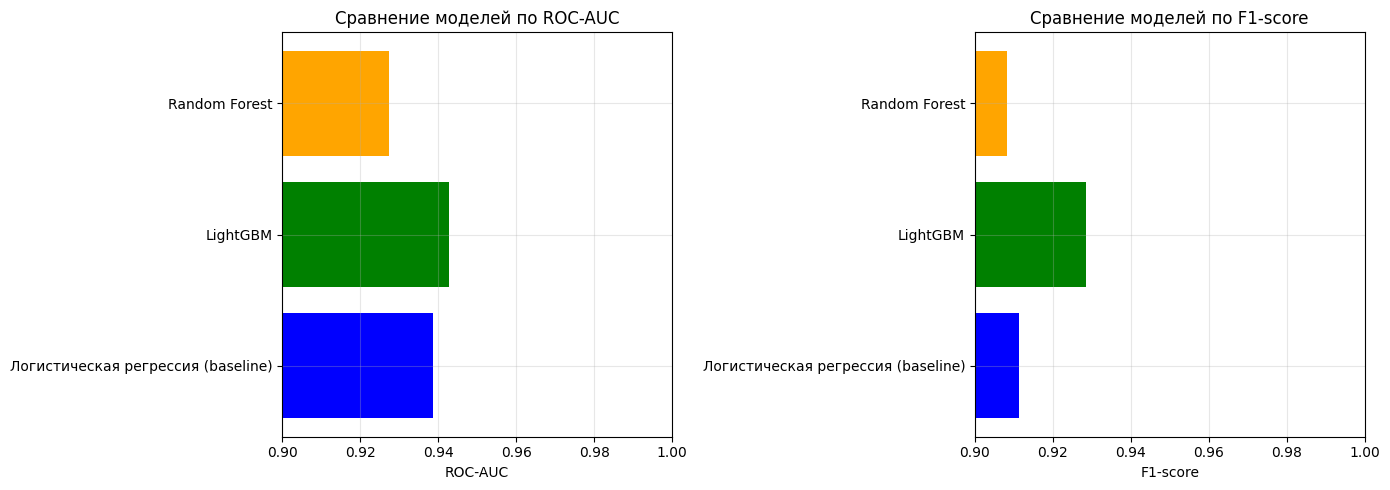

In [33]:
# Сравнение с baseline из 02_baseline
baseline_logreg = {
    'Model': 'Логистическая регрессия (baseline)',
    'Accuracy': 0.8682,
    'Precision': 0.9576,
    'Recall': 0.8695,
    'F1-score': 0.9114,
    'ROC-AUC': 0.9387
}

# Сводная таблица
results_comparison = pd.DataFrame([
    baseline_logreg,
    lgbm_metrics,
    rf_metrics
])

print("=" * 60)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ВСЕХ МОДЕЛЕЙ")
print("=" * 60)
print(results_comparison.to_string(index=False))
print("=" * 60)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(results_comparison['Model'], results_comparison['ROC-AUC'], 
             color=['blue', 'green', 'orange'])
axes[0].set_xlabel('ROC-AUC')
axes[0].set_title('Сравнение моделей по ROC-AUC')
axes[0].set_xlim(0.9, 1.0)
axes[0].grid(alpha=0.3)

axes[1].barh(results_comparison['Model'], results_comparison['F1-score'],
             color=['blue', 'green', 'orange'])
axes[1].set_xlabel('F1-score')
axes[1].set_title('Сравнение моделей по F1-score')
axes[1].set_xlim(0.9, 1.0)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 11.2 Финальные выводы

### Финальные выводы

#### 1. Лучшая модель

**LightGBM** показал лучшее качество среди всех моделей (включая baseline):
- **ROC-AUC**: 94.27%
- Превосходит baseline логистическую регрессию (93.87%)
- Обучается медленнее Random Forest
- Хорошо интерпретируется через SHAP

#### 2. Влияние подбора гиперпараметров

Подбор гиперпараметров позволил:
- Найти оптимальный баланс между сложностью модели и регуляризацией
- Предотвратить переобучение на разреженных TF-IDF признаках
- Улучшить качество по сравнению с дефолтными параметрами

#### 3. Интерпретация модели

Анализ важности признаков показал:
- **Текстовые признаки (TF-IDF)** доминируют в предсказании тональности
- Ключевые слова ("great", "not", "delicious") имеют наибольший вклад
- **Числовые признаки** (длина текста, HelpfulnessRatio) играют дополнительную роль
- Модель принимает **адекватные и объяснимые решения**

#### 4. Что можно попробовать в следующей итерации

1. **Улучшение представления текста**:
   - Word2Vec / GloVe embeddings вместо TF-IDF
   - BERT / Transformer-based models для учета контекста

2. **Ансамблирование**:
   - Стекинг (LightGBM + Random Forest + LogReg)
   - Voting classifier

3. **Дополнительные признаки**:
   - Sentiment lexicons (VADER, TextBlob)
   - Part-of-speech теги
   - Named entities

4. **Работа с дисбалансом**:
   - SMOTE / ADASYN для синтетической генерации примеров
   - Focal Loss вместо cross-entropy